## <center> Прогнозирование оттока клиентов банка

**Постановка задачи:**

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время.

**Задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой частибудут подготовлены данные для моделирования и построена простейшая модель логистической регрессии. Далее будет оценка её качества и проанализированы результаты её работы.

* Во второй части будет построена модель дерева решений и случайного леса.

* В завершении будет проведено сравнение моделей и сделан финальный вывод.


# Импортируем библиотеки

In [27]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
from scipy import stats
from sklearn import tree
from sklearn import ensemble

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import zipfile
import requests
%matplotlib inline
sns.set_theme('notebook')
sns.set_palette("RdPu")

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

# Подготовим некоторые функции, которые будем использовать в дальнейшем

In [3]:
def read_zip(url: str, zip_file_name: str) -> pd.DataFrame:
    """
    Функция скачивает ZIP-файл по указанной ссылке, извлекает CSV-файл из архива
    и читает его с помощью pandas.

    Аргументы:
    url (str): Ссылка на ZIP-архив, содержащий CSV-файл.
    zip_file_name (str): Название, с которым ZIP-файл будет сохранен локально.

    Возвращает:
    pandas.DataFrame: Данные из CSV-файла в формате DataFrame.
    """
    response = requests.get(url)

    # Сохраняем ZIP-файл локально
    with open(zip_file_name, 'wb') as file:
        file.write(response.content)

    # Открываем ZIP-архив для чтения
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        file_name = zip_ref.namelist()[0]
        df = pd.read_csv(zip_ref.open(file_name))

    return df

In [4]:
def check_normality(data, alpha=0.05):
    """
    Проверяет нормальность распределения данных с помощью теста Шапиро-Уилка.

    :data: Входные данные (одномерный массив или Series)
    :alpha: Уровень значимости (по умолчанию 0.05)
    :return: Результат теста и вывод о нормальности
    """
    # Выполнение теста Шапиро-Уилка
    stat, p_value = stats.shapiro(data)

    # Проверка p-значения
    if p_value > alpha:
        return "распределение нормально"
    else:
        return "распределение не нормально"


In [5]:
def test_manna(data, col, alpha=0.05):
  """
  Проводит непараметрический тест Манна-Уитни (U-тест).

  :data: Входные данные датафрейм пандас
  :col: Признак ля проведения теста
  :return: Результат теста и вывод
  """
  group1 = data[data['Exited'] == 0][col]
  group2 = data[data['Exited'] == 1][col]

  # Проведение теста Манна-Уитни
  stat, p_value = stats.mannwhitneyu(group1, group2)

  if p_value < alpha:
      print(f"p-значение: {p_value:.5f}. Признак {col} статистически значим для Exited.")
  else:
      print(f"p-значение: {p_value:.5f}. Признак {col} не статистически значим для Exited.")

# Приступаем к знакомству с данными

In [84]:
url = 'https://lms-cdn.skillfactory.ru/assets/courseware/v1/1e9752711f76fc98e2e431c7c65bb420/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ML-3_churn.zip'
zip_file_name = 'ML-3_churn.zip'
df = read_zip(url, zip_file_name)

# Выводим первые несколько строк загруженных данных
df.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [7]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,2500.75,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


In [8]:
df.select_dtypes(include=['object']).describe()

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [9]:
df.shape

(10000, 14)

* В нашем распоряжении находятся данные о 10,000 пользователей.
* В этом наборе данных преобладают мужчины. Возраст пользователей варьируется от 18 до 92 лет.
* Большинство клиентов происходят из Франции.
* Максимальное количество банковских продуктов, которыми могут владеть клиенты, составляет 4.
* Длительность клиентского обслуживания варьируется максимум от 0 до 10 лет.
* Заработная плата клиентов колеблется в пределах от 11 до 200,000.
* Баланс пользователей варьируется от 0 до 251,000.
* В данных отсутствуют пропуски.

**Посмотрим как распределяется в данных целевой признак**

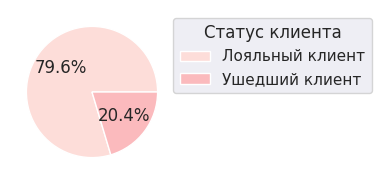

In [85]:
fig, axes = plt.subplots(figsize=(7, 2))

dict_replacement = {
                    0: 'Лояльный клиент',
                    1: 'Ушедший клиент'
                    }
df['Status'] = df['Exited'].map(dict_replacement)
clients = df['Status'].value_counts()

plt.pie(clients, autopct='%.1f%%')
axes.legend(
            clients.index,
            title='Статус клиента',
            loc='upper left',
            bbox_to_anchor=(0.95, 1)
            );
plt.tight_layout();
df = df.drop('Status', axis=1)

Данные не сбалансированы. Доля лояльных клиентов в данных значительно выше,чем доля ушедших.

**Смотрим как распределяются данные в каждом признаке**

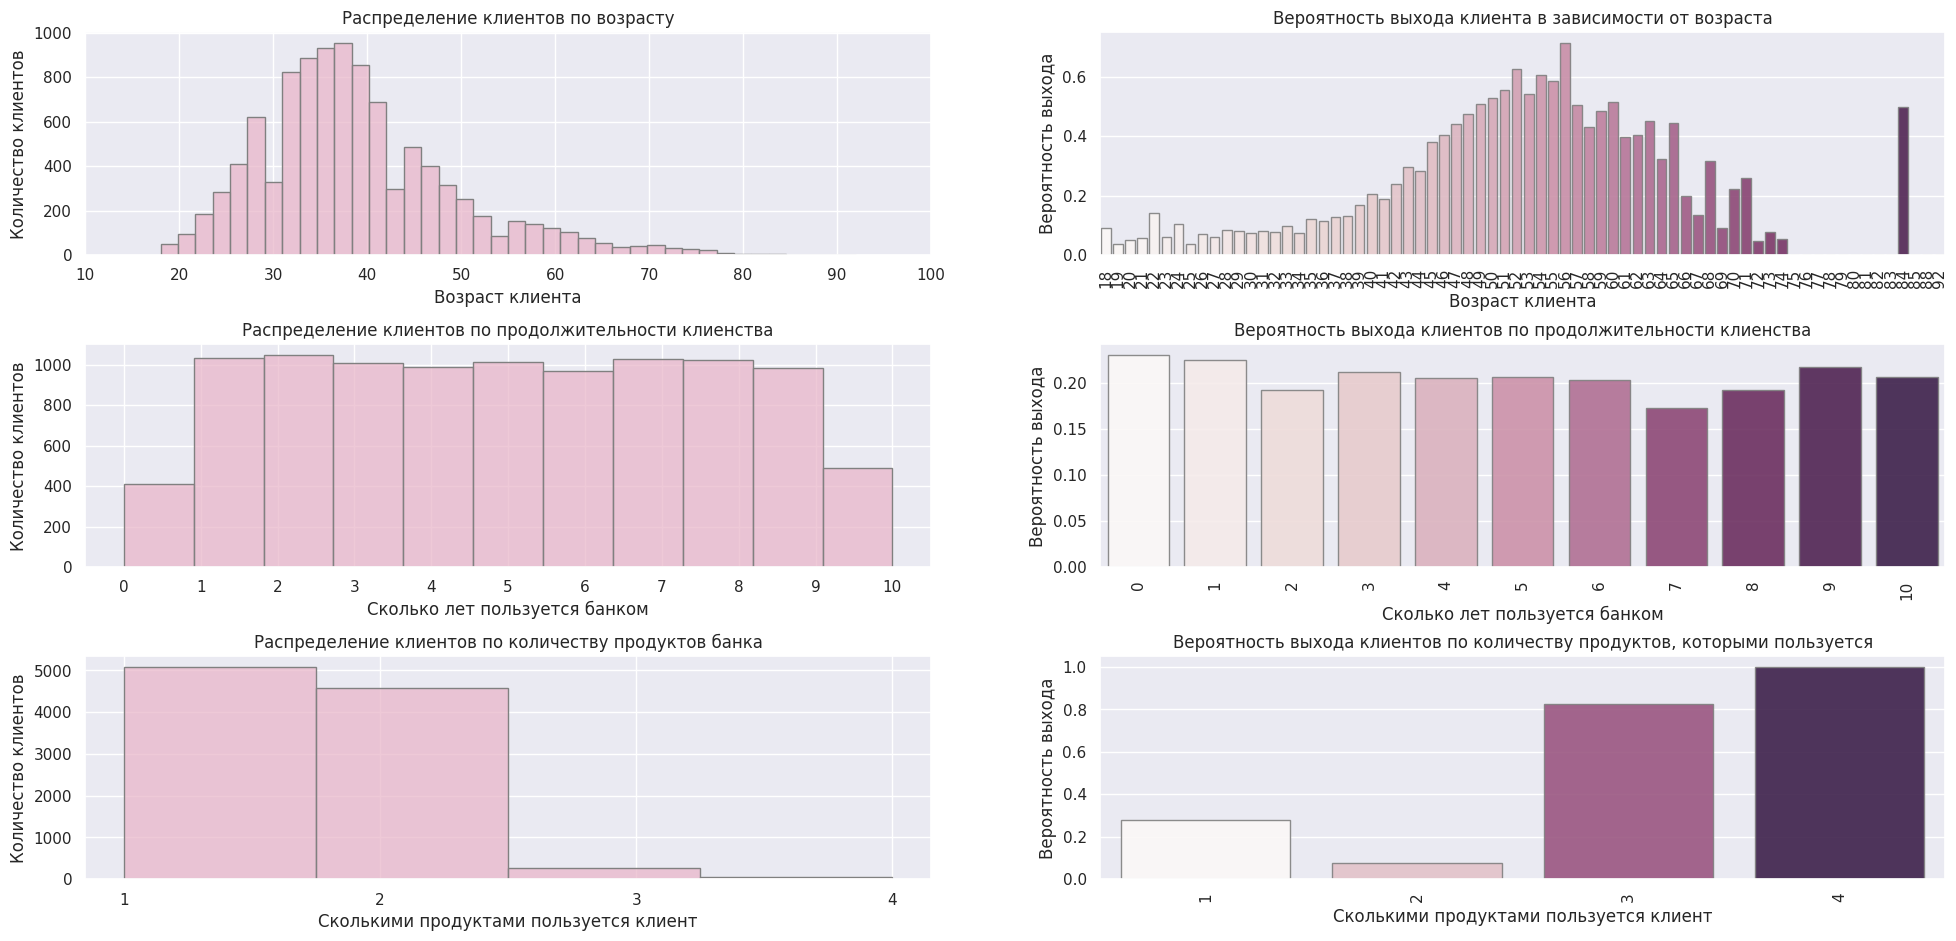

In [11]:
def plot_histogram(ax, data, x_col, color, title, xlabel, bins_, kde=False, element="bars", xticks=False):
    sns.histplot(data, x=x_col, color=color, edgecolor='grey', bins=bins_, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Количество клиентов')
    if not xticks:
      ax.set_xticks(ax.get_xticks())
    else:
      ax.set_xticks(xticks)
def plot_bar(ax, data, x_col, title, xlabel):
    group_df = df.groupby(x_col, observed=True)['Exited'].agg(['mean']).reset_index()

    sns.barplot(
        group_df,
        x=f'{x_col}',
        y='mean',
        hue=f'{x_col}',
        palette='RdPu',
        saturation=0.4,
        alpha=0.9,
        edgecolor='grey',
        legend=False,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Вероятность выхода')
    ax.tick_params(axis='x', rotation=90)

fig, axes = plt.subplots(3, 2, figsize=(24, 11))
plt.subplots_adjust(hspace=0.4)


# График 1: Распределение по возрасту
plot_histogram(axes[0][0], df, 'Age', '#e9b7ca',
               'Распределение клиентов по возрасту',
               'Возраст клиента',
               bins_=40
               )

plot_bar(axes[0][1], df, 'Age',
         title='Вероятность выхода клиента в зависимости от возраста',
         xlabel='Возраст клиента')

# График 2: Распределение по продолжительности клиенства
plot_histogram(axes[1][0], df, 'Tenure', '#e9b7ca',
               'Распределение клиентов по продолжительности клиенства',
               'Сколько лет пользуется банком',
               bins_=11,
               xticks=range(0,11)
               )

plot_bar(axes[1][1], df, 'Tenure',
         title='Вероятность выхода клиентов по продолжительности клиенства',
         xlabel='Сколько лет пользуется банком')

# График 3: Распределение по количеству продуктов
plot_histogram(axes[2][0], df, 'NumOfProducts', '#e9b7ca',
              'Распределение клиентов по количеству продуктов банка',
               'Сколькими продуктами пользуется клиент',
               bins_=4,
               xticks=range(1,5)
               )

plot_bar(axes[2][1], df, 'NumOfProducts',
         title='Вероятность выхода клиентов по количеству продуктов, которыми пользуется',
         xlabel='Сколькими продуктами пользуется клиент')

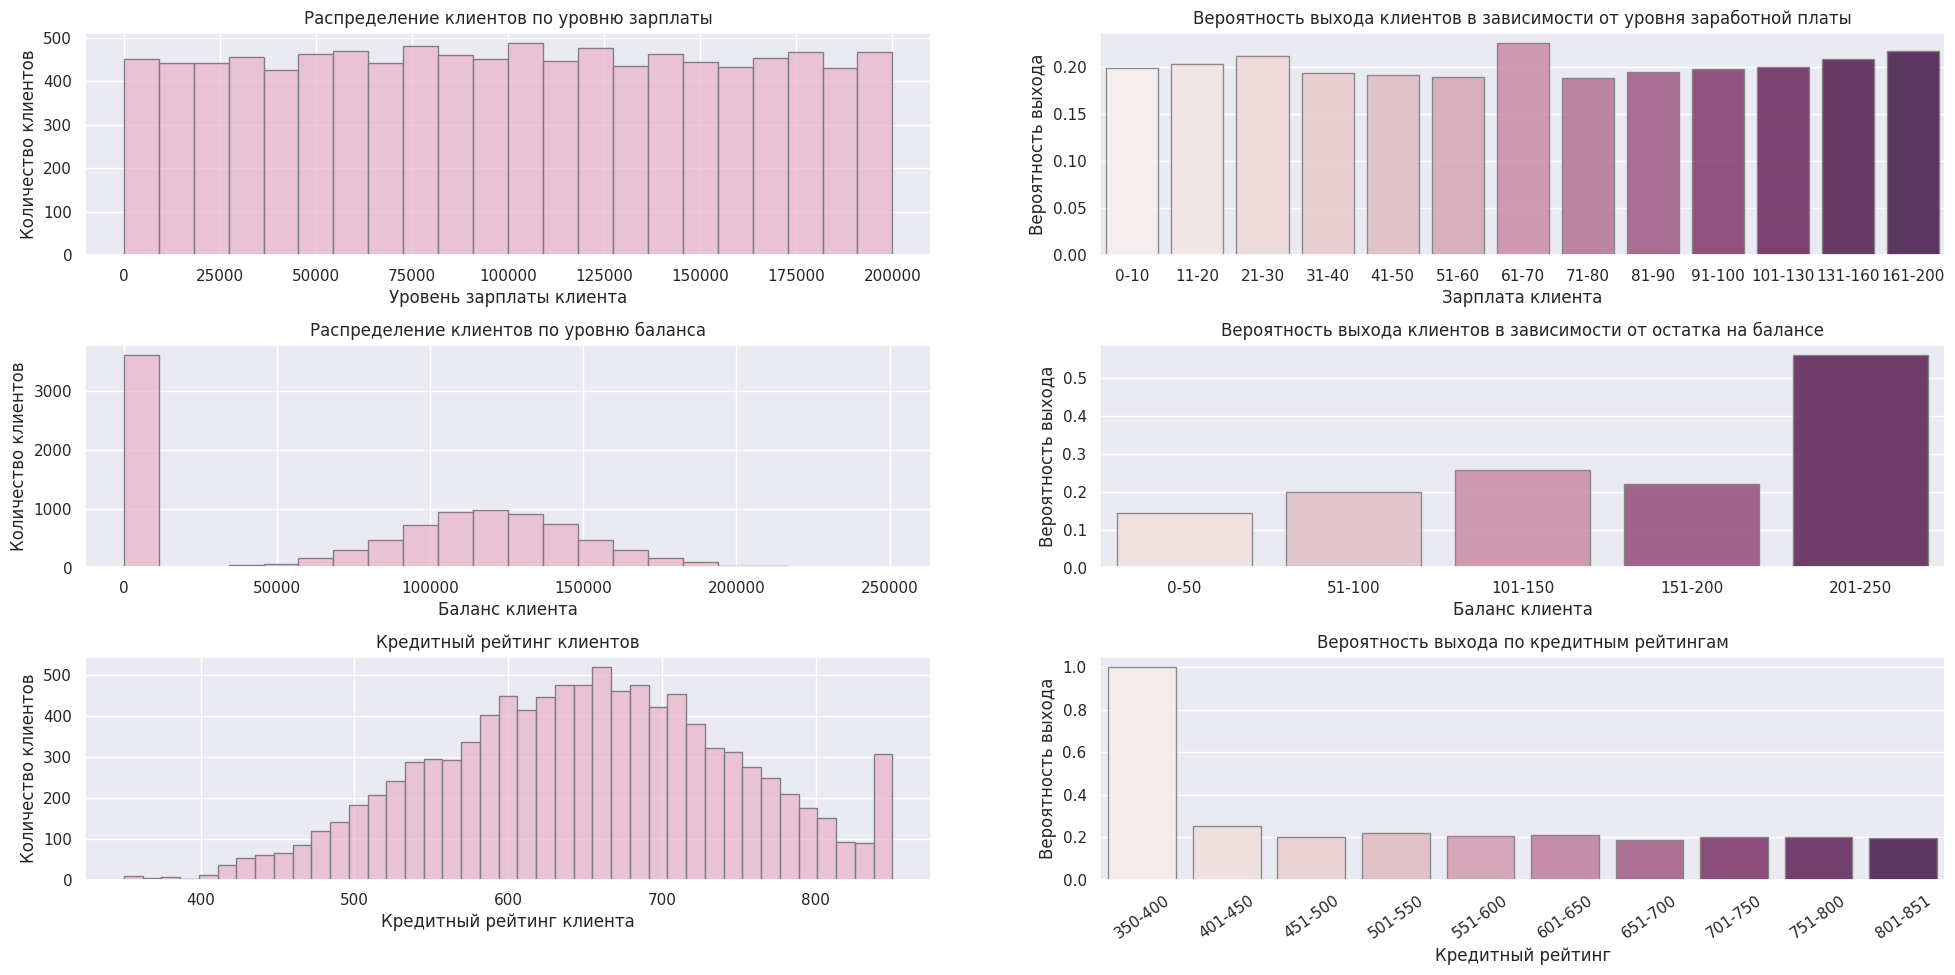

In [12]:
def plot_histogram(ax, data, x_col, color, title, xlabel, ylabel):
    sns.histplot(data, x=x_col, color=color, edgecolor='grey', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot_bar(ax, data, x_col, y_col, bins, labels, title, xlabel, ylabel, divide_by_thousand=True):
    df = data[[x_col, y_col]].copy()
    if divide_by_thousand:
      df[x_col] = df[x_col] // 1000
    df[f'{x_col}Bins'] = pd.cut(df[x_col], bins=bins, labels=labels, right=False)
    group_df = df.groupby(f'{x_col}Bins', observed=True)[y_col].agg(['mean']).reset_index()

    sns.barplot(
        group_df,
        x=f'{x_col}Bins',
        y='mean',
        hue=f'{x_col}Bins',
        palette='RdPu',
        saturation=0.4,
        alpha=0.9,
        edgecolor='grey',
        legend=False,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

fig, axes = plt.subplots(3, 2, figsize=(24, 11))
plt.subplots_adjust(hspace=0.4)

# График 1: Распределение по зарплате
plot_histogram(axes[0][0], df, 'EstimatedSalary', '#e9b7ca',
               'Распределение клиентов по уровню зарплаты',
               'Уровень зарплаты клиента',
               'Количество клиентов')

plot_bar(axes[0][1], df, 'EstimatedSalary', 'Exited',
         bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 130, 160, 200],
         labels=['0-10', '11-20', '21-30', '31-40', '41-50',
                 '51-60', '61-70', '71-80', '81-90', '91-100',
                 '101-130', '131-160', '161-200'],
         title='Вероятность выхода клиентов в зависимости от уровня заработной платы',
         xlabel='Зарплата клиента',
         ylabel='Вероятность выхода')

# График 2: Распределение по балансу
plot_histogram(axes[1][0], df, 'Balance', '#e9b7ca',
               'Распределение клиентов по уровню баланса',
               'Баланс клиента',
               'Количество клиентов')

plot_bar(axes[1][1], df, 'Balance', 'Exited',
         bins=[0, 50, 100, 150, 200, 251],
         labels=['0-50', '51-100', '101-150', '151-200', '201-250'],
         title='Вероятность выхода клиентов в зависимости от остатка на балансе',
         xlabel='Баланс клиента',
         ylabel='Вероятность выхода')

# График 3: Распределение по кредитному рейтингу
plot_histogram(axes[2][0], df, 'CreditScore', '#e9b7ca',
               'Кредитный рейтинг клиентов',
               'Кредитный рейтинг клиента',
               'Количество клиентов')

# Вероятность ухода клиента в зависимости от кредитного рейтинга
plot_bar(axes[2][1], df, 'CreditScore', 'Exited',
         bins=[350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 851],
         labels=['350-400', '401-450', '451-500', '501-550', '551-600',
          '601-650', '651-700', '701-750', '751-800', '801-851'],
         title='Вероятность выхода по кредитным рейтингам',
         xlabel='Кредитный рейтинг',
         ylabel='Вероятность выхода',
         divide_by_thousand=False)
plt.xticks(rotation=35)
plt.show();

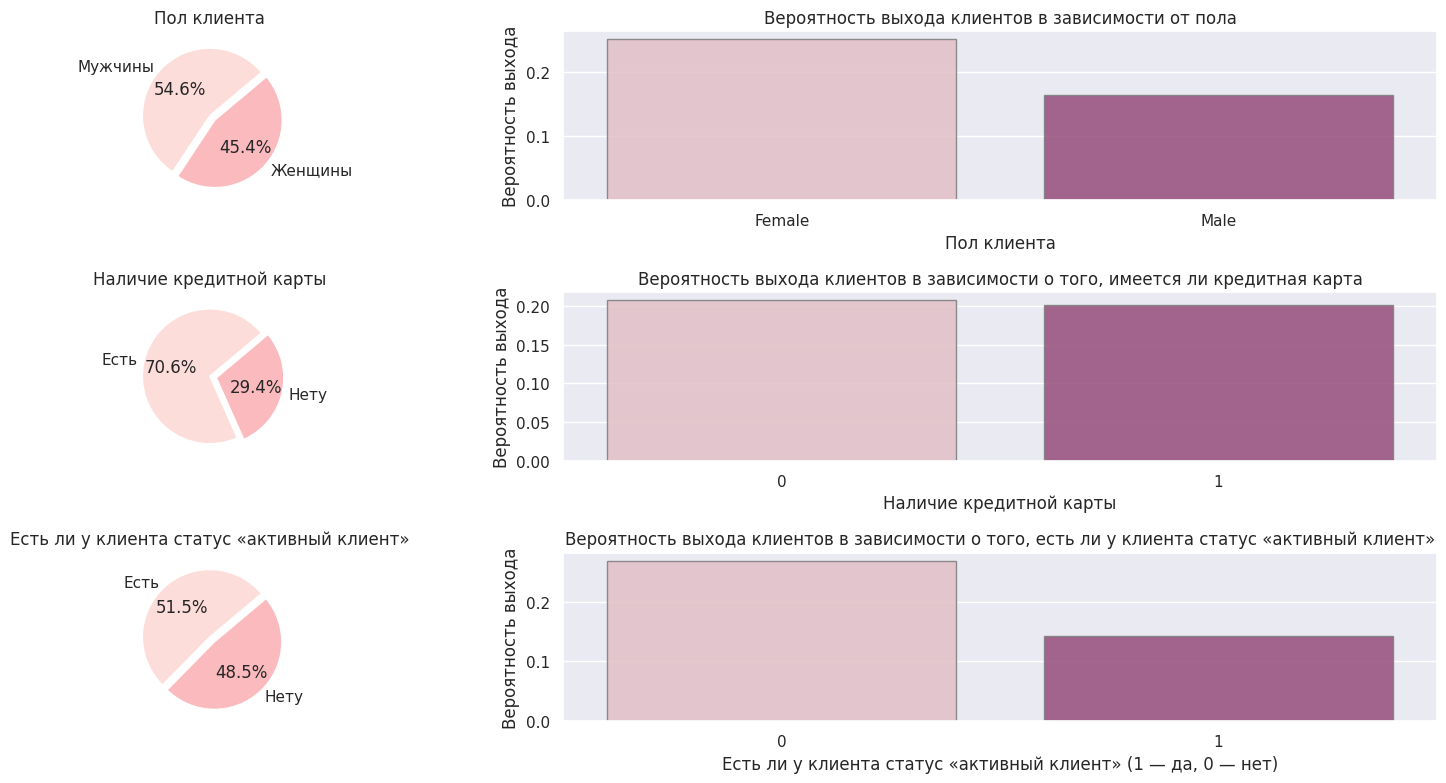

In [13]:
def plot_pie(ax, data, x_col, title, labels_):
    ax.pie(
      data[x_col].value_counts(),
      explode=(0, 0.1),
      startangle=40,
      labels = labels_,
      autopct='%.1f%%')
    ax.set_title(title)

def plot_bar(ax, data, x_col, title, xlabel):
    group_df = data.groupby(x_col, observed=True)['Exited'].agg(['mean']).reset_index()

    sns.barplot(
        group_df,
        x=x_col,
        y='mean',
        hue=x_col,
        palette='RdPu',
        saturation=0.4,
        alpha=0.9,
        edgecolor='grey',
        legend=False,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Вероятность выхода')


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(17,8))
plt.subplots_adjust(hspace=0.5)

# График 1: Распределение по полу клиента.
plot_pie(axes[0][0], df, 'Gender', 'Пол клиента', ['Мужчины', 'Женщины'])

# Вероятность выхода клиентов в зависимости от пола
plot_bar(
    axes[0][1],
    df,
    x_col='Gender',
    title='Вероятность выхода клиентов в зависимости от пола',
    xlabel='Пол клиента')

# График 2: Распределение по наличию кредитной карты.
plot_pie(axes[1][0], df, 'HasCrCard', 'Наличие кредитной карты', ['Есть', 'Нету'])

# Вероятность выхода клиентов в зависимости о того, имеется ли кредитная карта
plot_bar(
    axes[1][1],
    df,
    x_col='HasCrCard',
    title='Вероятность выхода клиентов в зависимости о того, имеется ли кредитная карта',
    xlabel='Наличие кредитной карты')

# График 3: Распределение по наличию у клиента статуса "активный клиент".
plot_pie(axes[2][0], df, 'IsActiveMember', 'Eсть ли у клиента статус «активный клиент»', ['Есть', 'Нету'])

# Вероятность выхода клиентов в зависимости о того, имеется ли кредитная карта
plot_bar(
    axes[2][1],
    df,
    x_col='IsActiveMember',
    title='Вероятность выхода клиентов в зависимости о того, есть ли у клиента статус «активный клиент»',
    xlabel='Eсть ли у клиента статус «активный клиент» (1 — да, 0 — нет)')

plt.tight_layout();

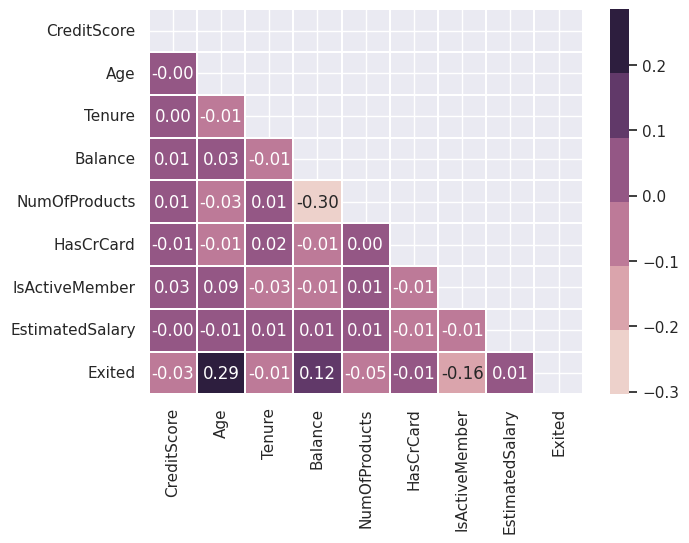

In [14]:
fig_, ax_ = plt.subplots(figsize=(7, 5))
corr = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
           'IsActiveMember', 'EstimatedSalary', 'Exited']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,
            annot=True,
            linewidths=0.1,
            ax=ax_,
            cmap=sns.cubehelix_palette(),
            mask=mask,
            fmt='.2f')
plt.show();

**На текущем этапе анализа можно сделать следующие выводы:**
*   Клиенты в возрасте от 45 до 66 лет наиболее подвержены риску ухода.
*   Оптимальное количество банковских услуг для клиента составляет 2. С увеличением или уменьшением этого количества вероятность ухода повышается.
*   Среди ушедших клиентов реже всего встречаются те, кто пользуется услугами банка от 2 до 8 лет.
*   Уровень заработной платы практически не оказывает влияния на вероятность ухода клиента в другой банк.
*   Лояльные клиенты чаще всего имеют минимальный баланс денежных средств.
*   Кредитный рейтинг не оказывает значительного влияния на лояльность клиентов. Исключением являются клиенты с очень низким кредитным рейтингом, у которых наблюдается повышенная вероятность ухода.
*   Количество мужчин и женщин в выборке примерно одинаково, однако женщины более склонны к уходу из банка.
*   Наличие кредитной карты у клиента практически не влияет на вероятность его ухода.









Отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [86]:
df = df[df['Geography'] == 'Germany']
df.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [87]:
df = df.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head(2)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0


Проверим, что в наших данных нет пропусков:

In [17]:
df.isnull().sum()

,0
CreditScore,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0
Exited,0


Проверим, что в наших данных нет дубликатов:

In [18]:
df[df.duplicated()].sum()

,0
CreditScore,0
Gender,0
Age,0
Tenure,0
Balance,0.00
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0.00
Exited,0


Давайте сделаем предобработку данных.

Для начала расширим датасет с помощью методов Feature Engineering. Создадим следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируем оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведим основные статистические характеристики полученных признаков.

In [88]:
# Создание новых признаков
df['BalanceSalaryRatio'] = df['Balance'] / df['EstimatedSalary']
df['TenureByAge'] = df['Tenure'] / df['Age']
df['CreditScoreGivenAge'] = df['CreditScore'] / df['Age']

# Извлечение и перекодировка категориальных признаков в бинарный формат
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Используем pd.get_dummies() для всех категориальных признаков и NumOfProducts с префиксом
df_encoded = pd.get_dummies(df[categorical_cols].astype(str), drop_first=True).astype('int')
df_products_encoded = pd.get_dummies(df['NumOfProducts'], prefix='NumOfProducts', drop_first=True).astype('int')

# Объединяем закодированные данные с основным DataFrame и удаляем оригинальные категориальные колонки
df_final = pd.concat([df.drop(categorical_cols, axis=1), df_encoded, df_products_encoded], axis=1)

In [91]:
df_final.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'BalanceSalaryRatio',
       'TenureByAge', 'CreditScoreGivenAge', 'Gender_Male', 'NumOfProducts_2',
       'NumOfProducts_3', 'NumOfProducts_4'],
      dtype='object')

In [92]:
for col in df_final.columns[-7:-4]:
  correlation = df_final[[col, 'Exited']].corr()
  print(f'Корреляция между {col} и Exited = {round(correlation["Exited"].iloc[0], 2)}')
print()
for col in df_final.columns[-7:-4]:
  # Проверка нормальности
  result = check_normality(df_final[col])
  print(f'В признаке {col} - {result}')
print()
for col in df_final.columns[-7:-4]:
  # Проверка статистической значимости
  test_manna(df_final, col)

Корреляция между BalanceSalaryRatio и Exited = 0.03
Корреляция между TenureByAge и Exited = -0.13
Корреляция между CreditScoreGivenAge и Exited = -0.3

В признаке BalanceSalaryRatio - распределение не нормально
В признаке TenureByAge - распределение не нормально
В признаке CreditScoreGivenAge - распределение не нормально

p-значение: 0.04201. Признак BalanceSalaryRatio статистически значим для Exited.
p-значение: 0.00000. Признак TenureByAge статистически значим для Exited.
p-значение: 0.00000. Признак CreditScoreGivenAge статистически значим для Exited.


Поработаем еще с признаками.
Создадим бинарные признаки для разных диапазонов возрастов клиентов.

In [93]:
df_final['AgeBetween18And41'] = (df_final['Age'] <= 41).astype('int')
df_final['AgeBetween42And47']= ((df_final['Age'] > 41) & (df_final['Age'] <= 47)).astype('int')
df_final['AgeBetween48And65']= ((df_final['Age'] > 47) & (df_final['Age'] <= 65)).astype('int')
df_final['AgeMore65'] = (df_final['Age'] > 65).astype('int')

In [94]:
df_final.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,AgeBetween18And41,AgeBetween42And47,AgeBetween48And65,AgeMore65
count,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00
mean,651.45,39.77,5.01,119730.12,1.52,0.71,0.50,101113.44,0.32,9.02,0.13,17.53,0.52,0.41,0.04,0.01,0.63,0.17,0.18,0.03
std,98.17,10.52,2.94,27022.01,0.62,0.45,0.50,58263.01,0.47,214.29,0.09,5.35,0.50,0.49,0.19,0.10,0.48,0.38,0.38,0.16
min,350.00,18.00,0.00,27288.43,1.00,0.00,0.00,11.58,0.00,0.19,0.00,6.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,584.00,32.00,2.00,102800.72,1.00,0.00,0.00,51016.02,0.00,0.78,0.06,13.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,651.00,38.00,5.00,119703.10,1.00,1.00,0.00,102397.22,0.00,1.20,0.12,16.86,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
75%,722.00,45.00,8.00,137560.38,2.00,1.00,1.00,151083.80,1.00,2.40,0.20,20.85,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
max,850.00,84.00,10.00,214346.96,4.00,1.00,1.00,199970.74,1.00,10614.66,0.50,46.39,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


# Перед тем как приступать к обучению нужно проверить корреляции и важность признаков.

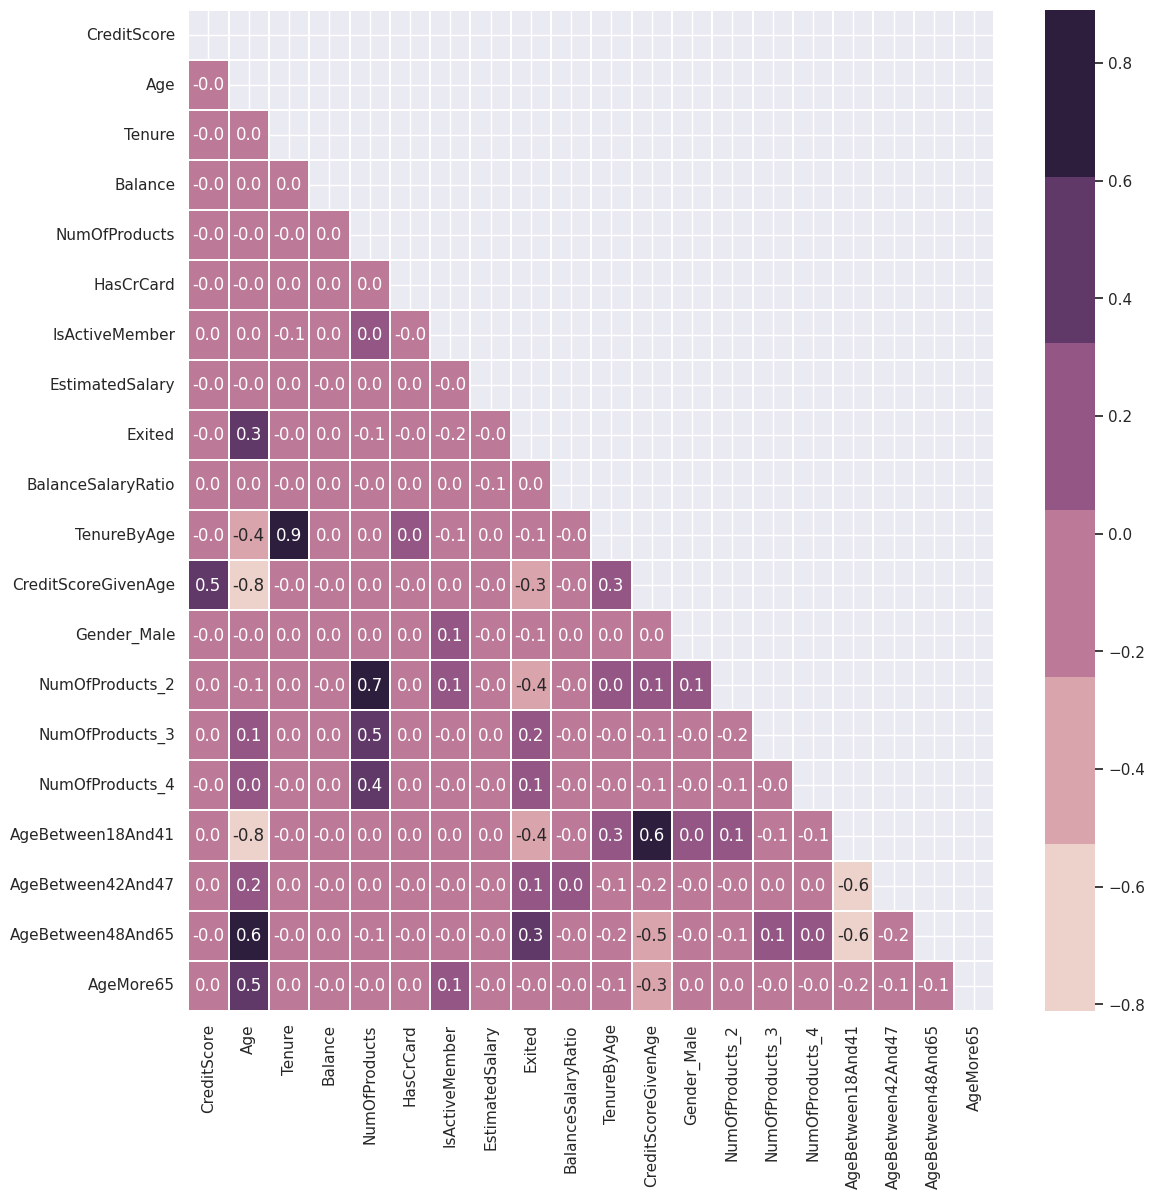

In [96]:
fig_, ax_ = plt.subplots(figsize=(13, 13))
corr = df_final.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,
            annot=True,
            linewidths=0.1,
            ax=ax_,
            cmap=sns.cubehelix_palette(),
            mask=mask,
            fmt='.1f')
plt.show();

У следующих признаков очень сильная корреляция, их необходимо удалить из данных.

In [97]:
df_final = df_final.drop(['Age', 'Tenure', 'NumOfProducts'], axis=1)

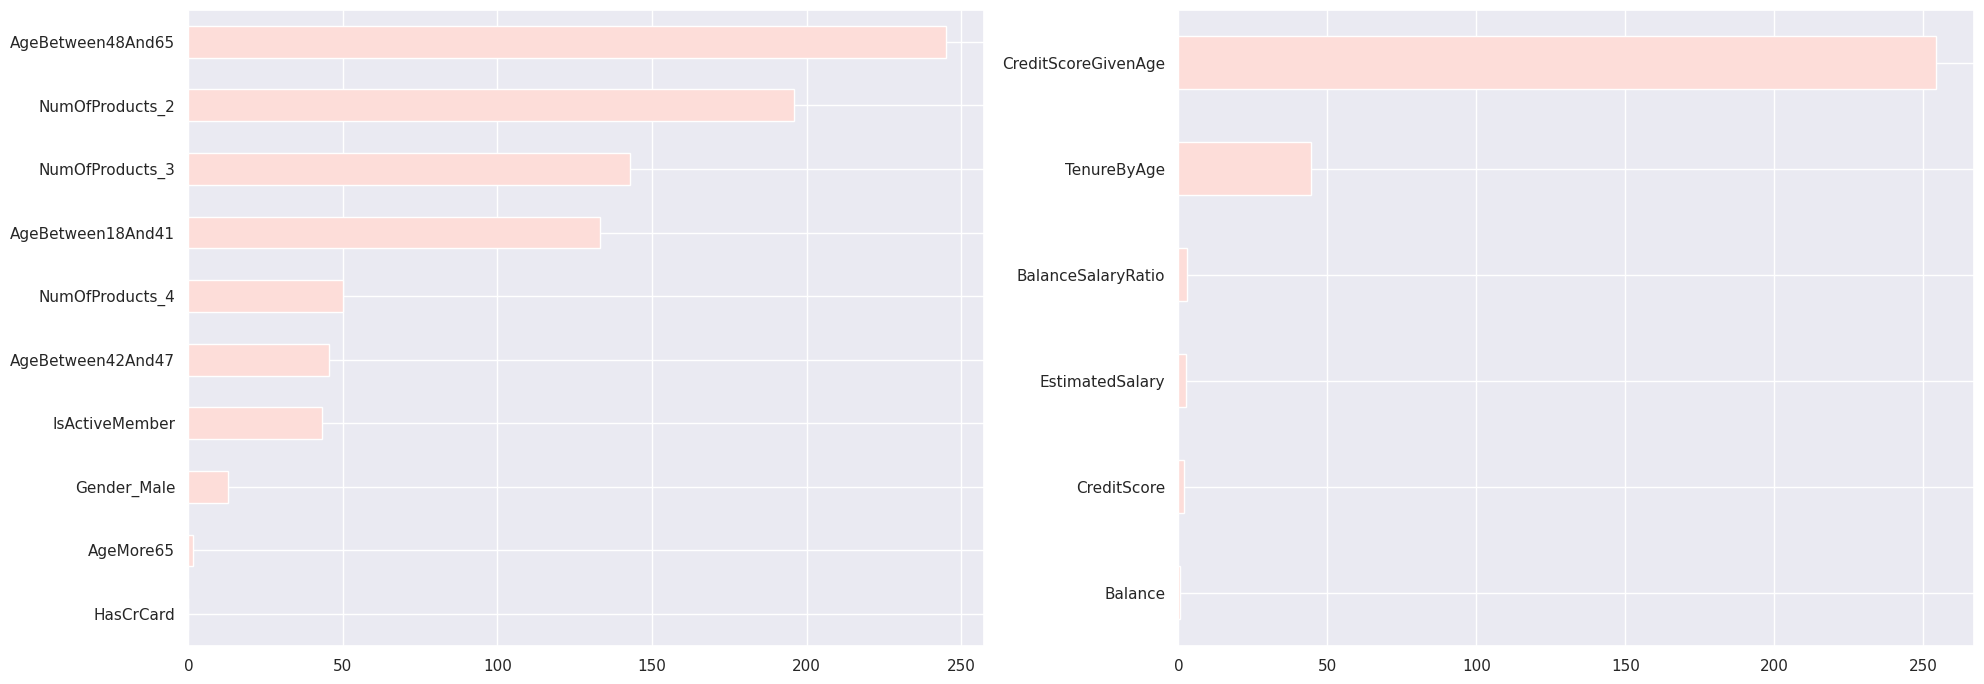

In [98]:
cat_cols = ['HasCrCard', 'IsActiveMember', 'Gender_Male', 'NumOfProducts_2', 'NumOfProducts_3',
            'NumOfProducts_4', 'AgeBetween18And41', 'AgeBetween42And47', 'AgeBetween48And65', 'AgeMore65']
num_cols = ['CreditScore', 'Balance', 'EstimatedSalary',  'BalanceSalaryRatio', 'TenureByAge', 'CreditScoreGivenAge']
y = df_final['Exited']

imp_cat = pd.Series(chi2(df_final[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)

fig5, ax5 = plt.subplots(1, 2, figsize=(20, 7))
imp_cat.plot(kind = 'barh', ax=ax5[0]);

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(df_final[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)

imp_num.plot(kind = 'barh', ax=ax5[1])
plt.tight_layout();

Удалим признаки, которые не важны для обучения.

In [99]:
df_final = df_final.drop(['HasCrCard', 'Balance'], axis=1)

Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет).

In [100]:
X = df_final.drop("Exited", axis=1)
y = df_final["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [31]:
y.value_counts(normalize=True)

,proportion
Exited,
0,0.68
1,0.32


Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.

**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**.

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y.

Выполним разбиение, установив значение параметра `random_state` на 0:

In [101]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y,
    stratify=y,
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 14)
Test shape: (628, 14)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [33]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


,proportion
Exited,
0,0.68
1,0.32




Test :


,proportion
Exited,
0,0.68
1,0.32


Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Позаботимся о масштабировании признаков. Проведем нормализацию/стандартизацию непрервных признаков.

>
>Для начала подберем подходящий скейлер и обучим его на тренировочной выборке (вычислим параметры трансформации) и применим трансформацию данных к тренировочной и тестовой выборкам.
>
>Так как в непрерывных признаках наблюдаются выбросы, а также данные не имеют нормального распределения, то лучшим выбором будет **RobustScaler.**
Он масштабирует данные с использованием медианы и межквартильного размаха (IQR). Это делает его более устойчивым к выбросам и лучше работает с данными, которые имеют нессиметричное распределение.

Но проведя обучение с различными скейлерами, лучшим решением является всетаки StandardScaler.


In [102]:
# Инициализация StandardScaler
scaler = StandardScaler()

# Список столбцов, которые нужно нормализовать
columns_to_scale = ['CreditScore', 'EstimatedSalary', 'BalanceSalaryRatio', 'TenureByAge', 'CreditScoreGivenAge']

# Подгоняем параметры стандартизатора (вычисляем min и max)
scaler.fit(X_train[columns_to_scale])

# Обучение скейлера на тренировочной выборке и трансформация данных
X_train_scaled = X_train.copy()  # Создаем копию данных для избежания изменения оригинала
X_test_scaled = X_test.copy()

# Нормализуем только выбранные столбцы
X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

> В данной задаче, где необходимо предсказывать отток клиентов и минимизировать как ложноположительные, так и ложноотрицательные срабатывания модели, наиболее подходящей метрикой будет F1-мерка.

* F1-мерка является гармоническим средним между точностью (precision) и полнотой (recall). Это важно в нашем случае, так как мы хотим минимизировать как ложноположительные, так и ложноотрицательные срабатывания. Высокая точность означает, что среди предсказанных "оттоков" действительно много клиентов, которые уйдут, а высокая полнота означает, что мы выявляем большинство клиентов, которые действительно собираются уйти.

* У нас в данных имеются нсбалансированные классы и  F1-мерка помогает лучше оценить качество модели в таких условиях, чем простая точность, которая может вводить в заблуждение.

# Обучим модель логистической регрессии (`Logistic Regression`)

In [103]:
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred = log_reg.predict(X_train_scaled)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred)))
#Делаем предсказание класса
y_pred_test = log_reg.predict(X_test_scaled)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 0.66
F1 score: 0.63


Попробуем улучшить результат, подобрав с помощью GridSearch оптимальные параметры для модели.

In [66]:
# Определение параметров для Grid Search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Регуляризация
    'penalty': ['l1', 'l2'], # Тип регуляризации
    'solver': ['liblinear', 'saga'],  # Алгоритмы оптимизации
    'class_weight': [None, 'balanced']  # Взвешивание классов
}

# Создание объекта логистической регрессии
log_reg_grid_search = linear_model.LogisticRegression(random_state=42, max_iter=1000)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=log_reg_grid_search, param_grid=param_grid,
                           scoring='f1', cv=5, n_jobs=-1, error_score='raise')

# Обучение модели
grid_search.fit(X_train_scaled, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Делаем предсказание на тестовой выборке с лучшей моделью
best_model_log_reg = grid_search.best_estimator_
y_pred_train = best_model_log_reg.predict(X_train_scaled)
y_pred_test = best_model_log_reg.predict(X_test_scaled)

# Рассчитываем F1-меру для тренировочной выборки лучшей модели
print('F1 score с лучшей моделью: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))

# Рассчитываем F1-меру для тестовой выборки лучшей модели
print('F1 score с лучшей моделью: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Лучшие параметры: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
F1 score с лучшей моделью: 0.68
F1 score с лучшей моделью: 0.68


# Сгенерируем полиномиальные признаки третьей степени для тренировочной и тестовой выборок.

In [104]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scaled)

#Создаём объект класса LogisticRegression
log_reg_poly = linear_model.LogisticRegression(random_state=42, max_iter=1000)
#Обучаем модель
log_reg_poly.fit(X_train_poly, y_train)

#Делаем предсказание класса
y_pred = log_reg_poly.predict(X_train_poly)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred)))
#Делаем предсказание класса
y_pred_test = log_reg_poly.predict(X_test_poly)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 0.72
F1 score: 0.64


На полиноминальных признаках третьей степени получаем явное переобучение. Поэтому поробуем использовать degree=2

In [105]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scaled)

#Создаём объект класса LogisticRegression
log_reg_poly = linear_model.LogisticRegression(random_state=42, max_iter=4000)
#Обучаем модель
log_reg_poly.fit(X_train_poly, y_train)

#Делаем предсказание класса
y_pred = log_reg_poly.predict(X_train_poly)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred)))
#Делаем предсказание класса
y_pred_test = log_reg_poly.predict(X_test_poly)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 0.68
F1 score: 0.65


**Теперь подберем лучшие параметры для модели с полиномиальными признаками второй степени**

In [106]:
# Определение параметров для Grid Search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Регуляризация
    'penalty': ['l1', 'l2'], # Тип регуляризации
    'solver': ['liblinear'],  # Алгоритмы оптимизации
    'class_weight': [None, 'balanced']  # Взвешивание классов
}

# Создание объекта логистической регрессии
log_reg_poly_grid = linear_model.LogisticRegression(random_state=42, max_iter=1000)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=log_reg_poly_grid, param_grid=param_grid,
                           scoring='f1', cv=5, n_jobs=-1, error_score='raise')

# Обучение модели
grid_search.fit(X_train_poly, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Делаем предсказание на тестовой выборке с лучшей моделью
best_model_log_reg_poly = grid_search.best_estimator_
y_pred_train = best_model_log_reg_poly.predict(X_train_poly)
y_pred_test = best_model_log_reg_poly.predict(X_test_poly)

# Рассчитываем F1-меру для тренировочной выборки лучшей модели
print('F1 score с лучшей моделью: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))

# Рассчитываем F1-меру для тестовой выборки лучшей модели
print('F1 score с лучшей моделью: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Лучшие параметры: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
F1 score с лучшей моделью: 0.69
F1 score с лучшей моделью: 0.69


# Подберем порог вероятности

Попробуем подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели будем использовать логистическую регрессию, обученную на полиномиальных признаках.

В качестве порога вероятности используем значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

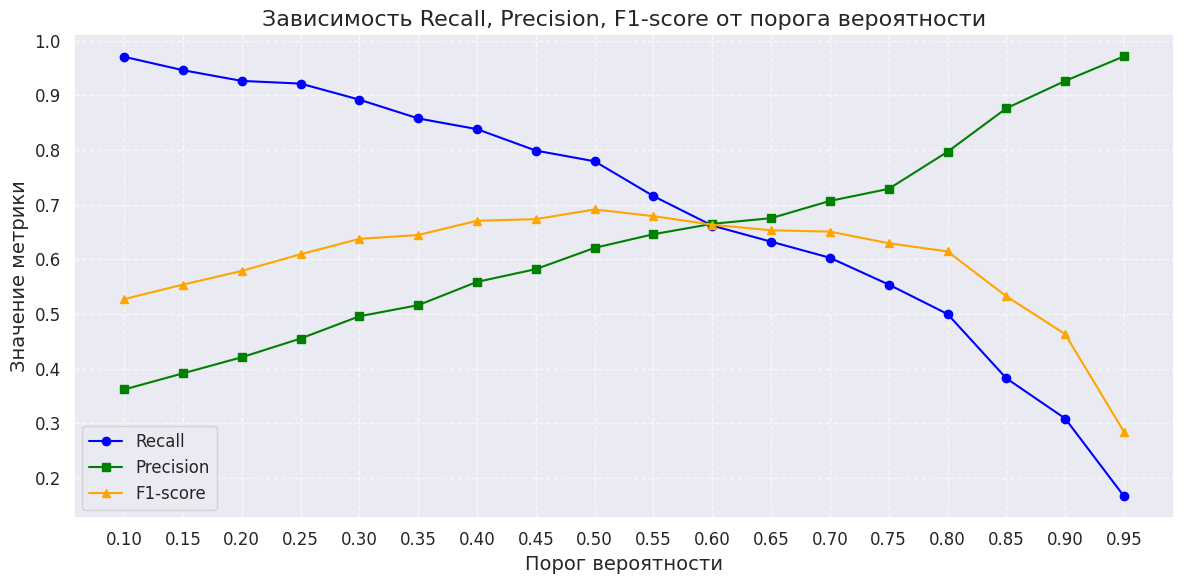

In [46]:
y_proba_pred = best_model_log_reg_poly.predict_proba(X_test_poly)[:, 1]
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred))


# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(12, 6))

# Строим графики для Recall, Precision и F1-score
ax.plot(thresholds, recall_scores, label='Recall', color='blue', linestyle='-', marker='o', markersize=6)
ax.plot(thresholds, precision_scores, label='Precision', color='green', linestyle='-', marker='s', markersize=6)
ax.plot(thresholds, f1_scores, label='F1-score', color='orange', linestyle='-', marker='^', markersize=6)

# Даём графику название и подписываем оси
ax.set_title('Зависимость Recall, Precision, F1-score от порога вероятности', fontsize=16)
ax.set_xlabel('Порог вероятности', fontsize=14)
ax.set_ylabel('Значение метрики', fontsize=14)

# Устанавливаем отметки по оси x
ax.set_xticks(thresholds)
# Устанавливаем размер шрифта для меток
ax.tick_params(axis='both', which='major', labelsize=12)
# Добавляем сетку для наглядности
ax.grid(True, linestyle='--', alpha=0.7)
# Отображаем легенду
ax.legend(loc='lower left', fontsize=12)

# Показать график
plt.tight_layout()
plt.show()

In [47]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.6
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# Рассчитываем F1-меру для тестовой выборки лучшей модели с новым порогом вероятности
print('F1 score с лучшими параметрами модели с полиноминальными признаками: {:.2f}'.format(metrics.f1_score(y_test, y_pred_opt)))

F1 score с лучшими параметрами модели с полиноминальными признаками: 0.66


# Теперь попробуем решить задачу с помощью деревьев решений.

Вернемся к финальному датафрейму до стандартизации.

In [48]:
X = df_final.drop("Exited", axis=1)
y = df_final["Exited"]

In [49]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y,
    stratify=y,
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 14)
Test shape: (628, 14)


**Обучим дерево решений без подбора параметров**

In [50]:
#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = dt_clf.predict(X_train)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
#Делаем предсказание класса
y_pred_test = dt_clf.predict(X_test)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 1.00
F1 score: 0.55


**Посмотрим, что оно из себя представляет**

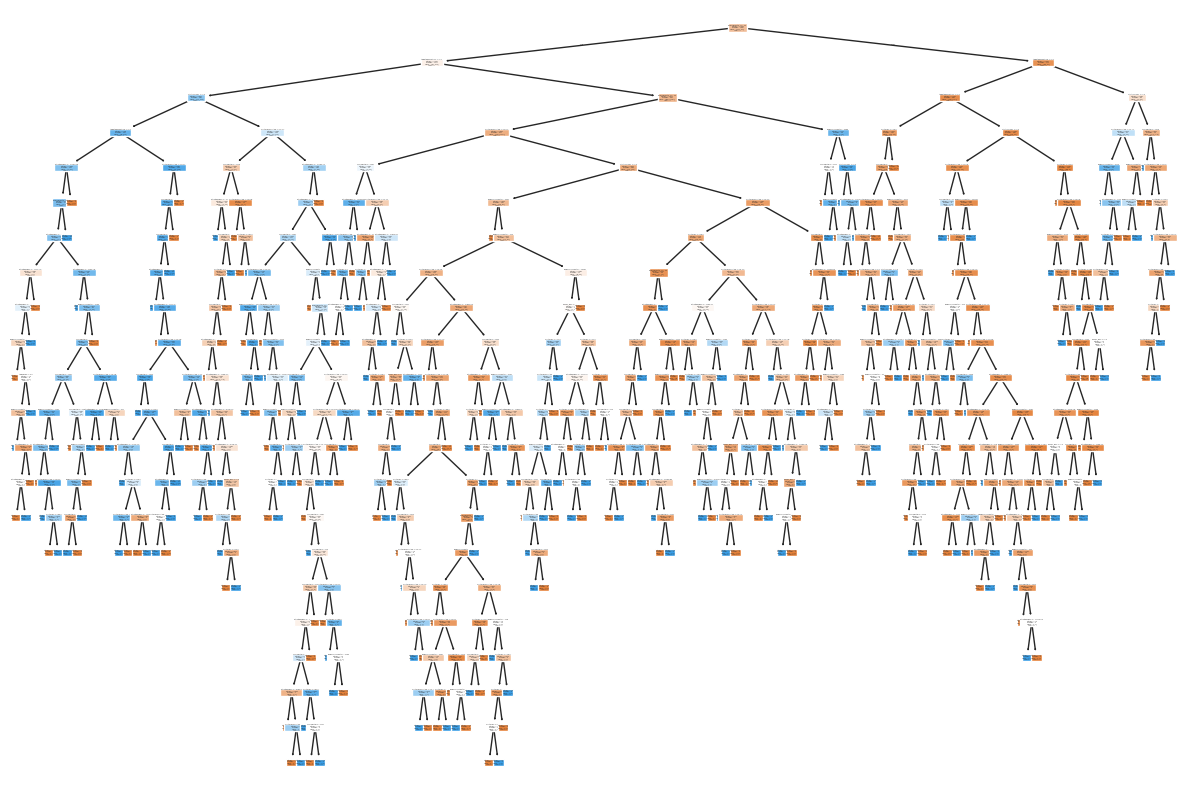

In [51]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф
tree_graph = tree.plot_tree(
    dt_clf, #объект обученного дерева
    feature_names=X_train.columns, #наименования факторов
    class_names=["0", "1"], #имена классов
    filled=True, #расцветка графа
);

In [52]:
dt_clf.get_depth()

21

Без ограничения максимальной глубины дерева, наше дерево стало задавать слишком много вопросов, полностью подстроивщись под тренировочные данные. Модель оказалась полностью переобученной.

**Давайте «подстрижём» наше дерево.**

Обучим на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используем энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

In [53]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_new = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=8,#максимальная глубина
    min_samples_leaf=10, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел
)
#Обучаем модель
dt_clf_new.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = dt_clf_new.predict(X_train)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
#Делаем предсказание класса
y_pred_test = dt_clf_new.predict(X_test)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 0.71
F1 score: 0.57


**Подберем оптимальные параметры**

In [54]:
max_depth = range(3,12)
min_samples_leaf = range(1,10)
for depth in max_depth:
  for leaf in min_samples_leaf:
    dt_clf_n = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=depth,
    min_samples_leaf=leaf,
    random_state=42
  )
    print(f'Параметры max_depth = {depth}, min_samples_leaf = {leaf}')
    # Обучаем модель
    dt_clf_n.fit(X_train, y_train)
    #Делаем предсказание класса
    y_pred_train = dt_clf_n.predict(X_train)
    #Рассчитываем F1-меру
    print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
    #Делаем предсказание класса
    y_pred_test = dt_clf_n.predict(X_test)
    #Рассчитываем F1-меру
    print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))
    print()

Параметры max_depth = 3, min_samples_leaf = 1
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 2
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 3
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 4
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 5
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 6
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 7
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 8
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 9
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 4, min_samples_leaf = 1
F1 score: 0.68
F1 score: 0.61

Параметры max_depth = 4, min_samples_leaf = 2
F1 score: 0.68
F1 score: 0.61

Параметры max_depth = 4, min_samples_leaf = 3
F1 score: 0.68
F1 score: 0.61

Параметры max_depth = 4, min_samples_leaf = 4
F1 score: 0.68
F1 score: 0.61


# Воспользуемся случайным лесом.

Построим случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.


In [55]:
#Создаём объект класса RandomForestClassifier
rf_clf= ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
#Обучаем модель
rf_clf.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = rf_clf.predict(X_train)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
#Делаем предсказание класса
y_pred_test = rf_clf.predict(X_test)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 0.69
F1 score: 0.62


# Подберем лучшие параметры

In [56]:
max_depth = range(3,12)
min_samples_leaf = range(1,12)

for depth in max_depth:
  for leaf in min_samples_leaf:

    rf_clf= ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=depth,
    min_samples_leaf=leaf,
    random_state=42
)
    print(f'Параметры max_depth = {depth}, min_samples_leaf = {leaf}')
    # Обучаем модель
    rf_clf.fit(X_train, y_train)
    #Делаем предсказание класса
    y_pred_train = rf_clf.predict(X_train)
    print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
    #Делаем предсказание класса
    y_pred_test = rf_clf.predict(X_test)
    print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))
    print()

Параметры max_depth = 3, min_samples_leaf = 1
F1 score: 0.63
F1 score: 0.57

Параметры max_depth = 3, min_samples_leaf = 2
F1 score: 0.63
F1 score: 0.57

Параметры max_depth = 3, min_samples_leaf = 3
F1 score: 0.63
F1 score: 0.57

Параметры max_depth = 3, min_samples_leaf = 4
F1 score: 0.63
F1 score: 0.56

Параметры max_depth = 3, min_samples_leaf = 5
F1 score: 0.63
F1 score: 0.56

Параметры max_depth = 3, min_samples_leaf = 6
F1 score: 0.62
F1 score: 0.56

Параметры max_depth = 3, min_samples_leaf = 7
F1 score: 0.62
F1 score: 0.56

Параметры max_depth = 3, min_samples_leaf = 8
F1 score: 0.62
F1 score: 0.57

Параметры max_depth = 3, min_samples_leaf = 9
F1 score: 0.62
F1 score: 0.57

Параметры max_depth = 3, min_samples_leaf = 10
F1 score: 0.62
F1 score: 0.56

Параметры max_depth = 3, min_samples_leaf = 11
F1 score: 0.62
F1 score: 0.56

Параметры max_depth = 4, min_samples_leaf = 1
F1 score: 0.68
F1 score: 0.60

Параметры max_depth = 4, min_samples_leaf = 2
F1 score: 0.68
F1 score: 0.6

Обучаем на лучших параметрах

In [57]:
#Создаём объект класса RandomForestClassifier
rf_clf_best = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=6,
    min_samples_leaf=10,
    random_state=42
)
#Обучаем модель
rf_clf_best.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = rf_clf_best.predict(X_train)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
#Делаем предсказание класса
y_pred_test = rf_clf_best.predict(X_test)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 0.68
F1 score: 0.61


# Подбираем порог вероятности на лучшей модели.

Попробуем подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке.

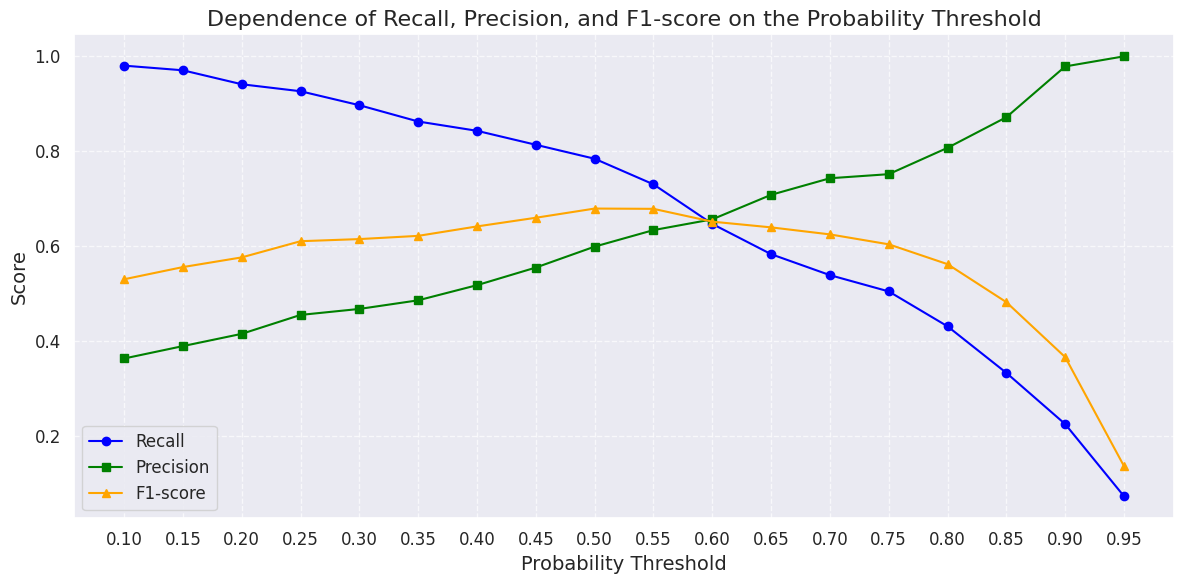

In [73]:
y_proba_pred = best_model_log_reg.predict_proba(X_test_scaled)[:, 1]
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred, zero_division=0))


# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(12, 6))

# Строим графики для Recall, Precision и F1-score
ax.plot(thresholds, recall_scores, label='Recall', color='blue', linestyle='-', marker='o', markersize=6)
ax.plot(thresholds, precision_scores, label='Precision', color='green', linestyle='-', marker='s', markersize=6)
ax.plot(thresholds, f1_scores, label='F1-score', color='orange', linestyle='-', marker='^', markersize=6)

# Даём графику название и подписываем оси
ax.set_title('Dependence of Recall, Precision, and F1-score on the Probability Threshold', fontsize=16)
ax.set_xlabel('Probability Threshold', fontsize=14)
ax.set_ylabel('Score', fontsize=14)

# Устанавливаем отметки по оси x
ax.set_xticks(thresholds)
# Устанавливаем размер шрифта для меток
ax.tick_params(axis='both', which='major', labelsize=12)
# Добавляем сетку для наглядности
ax.grid(True, linestyle='--', alpha=0.7)
# Отображаем легенду
ax.legend(loc='lower left', fontsize=12)

# Показать график
plt.tight_layout()
plt.show()

In [75]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.57
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# Рассчитываем F1-меру для тестовой выборки лучшей модели с новым порогом вероятности
print('F1 score с лучшей моделью: {:.2f}'.format(metrics.f1_score(y_test, y_pred_opt)))

F1 score с лучшей моделью: 0.67


# Переходим к предсказанию для нового клиента

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```
С помощью наилучшей модели спрогнозируем вероятность того, что Василий откажется от услуг банка.

In [69]:
new_client = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

# Создание новых признаков
new_client['BalanceSalaryRatio'] = new_client['Balance'] / new_client['EstimatedSalary']
new_client['TenureByAge'] = new_client['Tenure'] / new_client['Age']
new_client['CreditScoreGivenAge'] = new_client['CreditScore'] / new_client['Age']
new_client['AgeBetween18And41'] = (new_client['Age'] <= 41).astype('int')
new_client['AgeBetween42And47']= ((new_client['Age'] > 41) & (new_client['Age'] <= 47)).astype('int')
new_client['AgeBetween48And65']= ((new_client['Age'] > 47) & (new_client['Age'] <= 65)).astype('int')
new_client['AgeMore65'] = (new_client['Age'] > 65).astype('int')
new_client['Gender_Male'] = (new_client['Gender'] == 'Male').astype('int')
new_client['NumOfProducts_2'] = (new_client['NumOfProducts'] == 2.0).astype('int')
new_client['NumOfProducts_3'] = (new_client['NumOfProducts'] == 3.0).astype('int')
new_client['NumOfProducts_4'] = (new_client['NumOfProducts'] == 4.0).astype('int')
new_client[columns_to_scale] = scaler.transform(new_client[columns_to_scale])

y_proba_pred = best_model_log_reg.predict_proba(new_client[X_train.columns])[:, 1]
y_proba = best_model_log_reg.predict(new_client[X_train.columns])

In [109]:
print(f'Вероятность того, что клиент перестанет быть лояльным - {y_proba_pred}')
print(f'Прогнозируемый класс Exited нового клиента = {y_proba}')

Вероятность того, что клиент перестанет быть лояльным - [0.78823355]
Прогнозируемый класс Exited нового клиента = [1]


In [107]:
new_client = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

# Создание новых признаков
new_client['BalanceSalaryRatio'] = new_client['Balance'] / new_client['EstimatedSalary']
new_client['TenureByAge'] = new_client['Tenure'] / new_client['Age']
new_client['CreditScoreGivenAge'] = new_client['CreditScore'] / new_client['Age']
new_client['AgeBetween18And41'] = (new_client['Age'] <= 41).astype('int')
new_client['AgeBetween42And47']= ((new_client['Age'] > 41) & (new_client['Age'] <= 47)).astype('int')
new_client['AgeBetween48And65']= ((new_client['Age'] > 47) & (new_client['Age'] <= 65)).astype('int')
new_client['AgeMore65'] = (new_client['Age'] > 65).astype('int')
new_client['Gender_Male'] = (new_client['Gender'] == 'Male').astype('int')
new_client['NumOfProducts_2'] = (new_client['NumOfProducts'] == 2.0).astype('int')
new_client['NumOfProducts_3'] = (new_client['NumOfProducts'] == 3.0).astype('int')
new_client['NumOfProducts_4'] = (new_client['NumOfProducts'] == 4.0).astype('int')
new_client[columns_to_scale] = scaler.transform(new_client[columns_to_scale])
new_client = poly.transform(new_client[X_train.columns])

y_proba_pred = best_model_log_reg_poly.predict_proba(new_client)[:, 1]
y_proba = best_model_log_reg_poly.predict(new_client)

In [110]:
print(f'Вероятность того, что клиент перестанет быть лояльным - {y_proba_pred}')
print(f'Прогнозируемый класс Exited нового клиента = {y_proba}')

Вероятность того, что клиент перестанет быть лояльным - [0.8235577]
Прогнозируемый класс Exited нового клиента = [1]


**Для более точного результата итоговую вероятность ухода клиента можно получить путем объединения результатов обеих моделей. Самый простой вариант взять среднее от 2х вероятностей (0.8058956)*

# Подведем итог
При обучении на таких признаках:

*Исходные:*
1. 'CreditScore'
2. 'Age'
3. 'Balance'
4. 'HasCrCard'
2. 'IsActiveMember'
3. 'EstimatedSalary'

*Новые признаки:*
1. 'BalanceSalaryRatio'
2. 'TenureByAge'
3. 'CreditScoreGivenAge'
4. 'Gender_Male'

**Логистическая регрессия дала:**
* F1 score: 0.52 тренировочные данные
* F1 score: 0.50 тестовые данные

После подбора оптимальных параметров(C = 0.1, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')

F1 score с лучшей моделью: 0.60
F1 score с лучшей моделью: 0.58

**С полиномиальными признаками третьей степени:**
* F1 score: 0.51 тренировочные данные
* F1 score: 0.48 тестовые данные

**С полиномиальными признаками второй степени:**
* F1 score: 0.51 тренировочные данные
* F1 score: 0.49 тестовые данные

После подбора оптимальных параметров(C = 10, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear')
* F1 score: 0.69 тренировочные данные
* F1 score: 0.69 тестовые данные

После выбора оптимального порога вероятности 0.6, F1 scorе стала на уровне 0.66. Максимальный скор наблюдается при пороге в 0.5

**Дерево решений**
* F1 score: 1.00 тренировочные данные
* F1 score: 0.54 тестовые данные

С параметрами max_depth = 8, min_samples_leaf = 10

* F1 score: 0.72 тренировочные данные
* F1 score: 0.66 тестовые данные

С подбором оптимальных параметров (max_depth = 11, min_samples_leaf = 9):
* F1 score: 0.78 тренировочные данные
* F1 score: 0.66 тестовые данные

**Случайный лес**

Параметры(n_esminators = 500, max_depth = 8, min_samples_leaf = 10)
* F1 score: 0.74 тренировочные данные
* F1 score: 0.64 тестовые данные

После подбора оптимальных параметров(n_esminators = 500, max_depth = 6, min_samples_leaf = 10)
* F1 score: 0.70
* F1 score: 0.67

Попробуем сместить порог вероятности (0.4) для случайного леса F1 score стал равен 0.69

**Итоговое предсказание**
Вероятность того, что клиент перестанет быть лояльным - [0.5716376]
Прогнозируемый класс Exited нового клиента = [1]

**При данных признаках лучшими моделью стал случайный лес с порогом вероятности 0.4**


При обучении на таких признаках:

*Исходные:*
1. 'CreditScore'
2. 'IsActiveMember'
3. 'EstimatedSalary'

*Новые признаки:*
1. 'BalanceSalaryRatio'
2. 'TenureByAge'
3. 'CreditScoreGivenAge'
4. 'Gender_Male'
5. 'NumOfProducts_2'
6. 'NumOfProducts_3'
7. 'NumOfProducts_4'
8. 'AgeBetween18And41'
9. 'AgeBetween42And47'
10. 'AgeBetween48And65'
11. 'AgeMore65'

**Логистическая регрессия дала:**
* F1 score: 0.66 тренировочные данные
* F1 score: 0.63 тестовые данные

После подбора оптимальных параметров(C = 1, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')

F1 score с лучшей моделью: 0.68
F1 score с лучшей моделью: 0.68

**С полиномиальными признаками третьей степени:**
* F1 score: 0.72 тренировочные данные
* F1 score: 0.64 тестовые данные

**С полиномиальными признаками второй степени:**
* F1 score: 0.68 тренировочные данные
* F1 score: 0.65 тестовые данные

После подбора оптимальных параметров(C = 10, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear')
* F1 score: 0.69 тренировочные данные
* F1 score: 0.69 тестовые данные

После выбора оптимального порога вероятности 0.6, F1 score также стала на уровне 0.66. Максимальный скор наблюдается при пороге в 0.5

**Дерево решений**
* F1 score: 1.00 тренировочные данные
* F1 score: 0.54 тестовые данные

С параметрами max_depth = 8, min_samples_leaf = 10

* F1 score: 0.72 тренировочные данные
* F1 score: 0.57 тестовые данные

С подбором оптимальных параметров (max_depth = 3, min_samples_leaf = 1):
* F1 score: 0.66 тренировочные данные
* F1 score: 0.64 тестовые данные

**Случайный лес**

Параметры(n_esminators = 500, max_depth = 8, min_samples_leaf = 10)
* F1 score: 0.69 тренировочные данные
* F1 score: 0.62 тестовые данные

После подбора оптимальных параметров(n_esminators = 500, max_depth = 8, min_samples_leaf = 1)
* F1 score: 0.74
* F1 score: 0.64

Попробуем сместить порог вероятности (0.57) для логистической регрессии без полиномиальных признаков F1 score стал равен 0.67

**Итоговое предсказание**

Логистическая регрессия

Вероятность того, что клиент перестанет быть лояльным - [0.78823355]
Прогнозируемый класс Exited нового клиента = [1]

Логистическая регрессия с полиномиальными признаками

Вероятность того, что клиент перестанет быть лояльным - [0.8235577]
Прогнозируемый класс Exited нового клиента = [1]

**При данных признаках лучшими моделями стали логистическая регрессия и логистическая регрессия с полиномиальными признаками. Обе эти модели дали самые высокие значения F1 score, а также обе модели предсказали то, что клиент скорее всего откажется от услуг банка**
